In [1]:
import numpy as np
import constants
import quaternion as qt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from eulerangles import matrix2euler

In [2]:
def RK4(f, x0x1, y0, step, save_steps :int = 1, step_process = lambda y: y):
    # f MUST takes x and y as arguments: f(x, y)
    # It solves equation y' = f(x, y), y(x0) = y0 (everything is a vector)
    # from x0x1[0] to x0x1[1] on the grid with step step
    # save_steps - INT >= 1; integrator will save results every save_steps steps (2 - every second step, 1 - every step, etc.)
    # save_steps doesn't affect starting point and final point
    # step_process - FUNCTION that is called after every step to somehow process results (normalization and so on)
    # step_process - must take y argument (for single time step) as input and return the same shape numpy.ndarray
    # by default it doesn't do anything
    # returns array of (x, y) pairs
    if not isinstance(save_steps, int):
        raise TypeError("save_steps MUST be an integer")
    elif save_steps <= 0:
        raise ValueError("save_steps MUST be a natural number (1, 2, 3, ...)")
    
    x0 = x0x1[0]
    x1 = x0x1[1]
    current_x = np.array(x0, dtype = np.float64)
    current_y = np.array(y0, dtype = np.float64)
    result = [[x0, *y0]]
    h = step
    h2 = h/2
    h6 = h/6
    stop = x1 - h
    ind = 0
    while current_x < stop:
        ind += 1
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_y = step_process(current_y)
        current_x += h
        if ind == save_steps:
            result.append(np.array([current_x.copy(), *current_y.copy()]))
            ind = 0

    if current_x < x1 - constants.max_to_zero:
        h = x1 - current_x
        h2 = h/2
        h6 = h/6
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_y = step_process(current_y)
        current_x += h
        result.append(np.array([current_x.copy(), *current_y.copy()]))       
    
    return np.array(result)


class parameters:
    pass

J = np.zeros((3, 3))
J[0,0] = 1
J[1, 1] = 3
J[2, 2] = 2
Jinv = np.linalg.inv(J)

params = parameters()
params.J = J
params.Jinv = Jinv
params.mu = constants.muE

### Решается система уравнений:
$$
\dot{\textbf{r}}=\textbf{V}\\
\dot{\textbf{V}}=\frac{-\mu\textbf{r}}{r^3}\\
\dot{\textbf{w}}=\textbf{J}^{-1}(\textbf{M}(\textbf{r}, \Lambda)-\textbf{w}\times\textbf{J}\textbf{w})\\
\dot{\Lambda}=\frac{1}{2}\Lambda\circ\textbf{w}\\
where\\
\textbf{M}=\frac{3\mu}{r^3}\textbf{E}_{3}\times\textbf{JE}_{3}\\(everything\;must\;be\;in\;bound\;frame)\\
\textbf{E}_3=\frac{\textbf{r}}{r}
$$  
Радиус-вектор и скорость отделяются, поэтому их я буду интегрировать отдельно, а затем результат использовать при интегрировании углового движения.
Вообще, хотелось бы понимать ориентацию КА относительно орбитальной системы координат (ОСК), поэтому стоит совершить некоторые преобразования:
$$
\textbf{E}_3 = \frac{\textbf{r}}{r}\\
\textbf{E}_1 = \frac{\textbf{V} - \textbf{E}_3(\textbf{V},\textbf{E}_3)}{|\textbf{V}-\textbf{E}_3(\textbf{V},\textbf{E}_3)|}\\
\textbf{E}_2 = \textbf{E}_3\times\textbf{E}_1\\
\textbf{E}_1,\textbf{E}_2,\textbf{E}_3\rightarrow\textbf{S}_{irf->orf}\:-\:conversion\;matrix:\:\textbf{x}^o=\textbf{S}\textbf{x}^i\\
\Lambda\rightarrow \textbf{S}_{irf->brf}\:-\:conversion\;matrix:\:\textbf{x}^e=\textbf{S}\textbf{x}^i\\
\textbf{S}_{orf-brf}=\textbf{S}_{irf-brf}\textbf{S}^{T}_{irf-orf}\:-\:conversion\;matrix\;from\;orbital\;reference\;frame\;to\;bounded\\
\textbf{w}=\textbf{w}_{ors}+\textbf{w}_{r}\:(r\:-\:relative,\:ors\:-\:orbital\;reference\;system)\\
\textbf{w}_{ors} = \textbf{E}_2\frac{(\textbf{V},\textbf{E}_1)}{r}\\
$$

In [3]:
# Теперь угловая скорость и кватернион ориентации

# def Quat2Mat(Ai):
#     # Ai - array with 4 quaternion components
#     # returns S - transform matrix like in LINEAR ALGEBRA
#     w = Ai[0]
#     x = Ai[1]
#     y = Ai[2]
#     z = Ai[3]
#     return np.array([[1 - 2 * y**2 - 2 * z**2, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
#                     [2*x*y + 2*z*w, 1 - 2 * x**2 - 2 * z**2, 2*y*z - 2*x*w],
#                     [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2 * x**2 - 2 * y**2]])

def Torque(t, r, V, we, A, params):
    # xe = ST * xi = A.inverse * xi * A
    rr = np.linalg.norm(r)
    e3 = r / rr # in ifr
    A = np.quaternion(*A)
    e3 = (A.inverse() * np.quaternion(*e3) * A).vec # convertion to bound basis
    Me = 3 * params.mu / rr**3 * np.cross(e3, params.J @ e3)
    return Me

def QuatDot(Ai, we):
    return np.quaternion(*Ai) * np.quaternion(*we) * 0.5

def Euler(t, r, V, we, A, params, M = lambda t, r, V, we, A: np.array([0, 0, 0])):
    # return w' accroding to Euler's dinamic equation
    # A - orientation QUATERNION
    # M(t, w, A) - function of external moment in bounded axes
    return params.Jinv @ (M(t, r, V, we, A, params) - np.cross(we, params.J @ we))

def f(t, x, params):
    # x[:3] - r, x[3:6] - V, x[6:9] - we, x[9:] - Ai
    r = x[:3]
    V = x[3:6]
    we = x[6:9]
    A = x[9:]
    
    res = np.empty(13)
    res[:3] = V
    res[3:6] = -params.mu * r / np.linalg.norm(r)**3
    res[6:9] = Euler(t, r, V, we, A, params, Torque)
    res[9:] = QuatDot(A, we).components
    return res

def normalization(x):
    x[9:] /= np.linalg.norm(x[9:])
    return x


In [4]:
t0 = 0
t1 = 92*60
step = 0.1

r0 = np.array([1, 0, 0]) * (constants.RE + constants.ISS_periapsis)
# хочу круговую орбиту
V0 = np.array([0 , 1, 0]) * np.sqrt(params.mu/np.linalg.norm(r0))
we0 = np.array([0.01, 0.01, 0.01])
A0 = np.quaternion(0.5, 0.5, 0.5, 0.5) # ОСК и ССК совпадают

x0 = np.hstack((r0, V0, we0, A0.components))

resultang = RK4(lambda t, x: f(t, x, params), (t0, t1), x0, step, step_process = normalization)

In [5]:
timepoints = resultang[:, 0]
r = resultang[:, 1:4]
V = resultang[:, 4:7]
we = resultang[:, 7:10]
A = resultang[:, 10:]

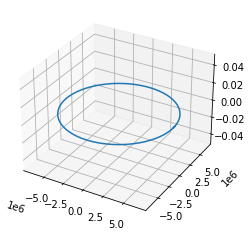

In [6]:
# Траектория спутника
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(r[:, 0], r[:, 1], r[:, 2])
pass

In [7]:
# Теперь роассмотрим поведение относительно ОСК
E3 = np.array([i / np.linalg.norm(i) for i in r])

E1 = np.array([(i - j * np.dot(i, j)) for i, j in zip(V, E3)])
for i in range(E1.shape[0]):
    E1[i] /= np.linalg.norm(E1[i])

E2 = np.array([np.cross(i, j) for i, j in zip(E3, E1)])

In [8]:
S1 = np.array([np.array([E1[i], E2[i], E3[i]]) for i in range(E1.shape[0])]) # матрицы перехода ИСК -> ОСК x' = Sx (НЕ линал)
S2 = np.array([qt.as_rotation_matrix(np.quaternion(*i)).T for i in A]) # матрицы перехода ИСК -> ССК x' = Sx (НЕ линал)
S3 = np.array([j @ i.T for i, j in zip(S1, S2)]) # матрицы перехода ОСК -> ССК x' = Sx (НЕ линал)
A3 = np.array([qt.from_rotation_matrix(i.T).components for i in S3]) # кватернионы поворота ОСК -> CCК

# Сделаю компоненты кватерниона более гладкими (а то у них знак скачет туда-сюда)
# Мой костыльный метод дальше, когда равновесие искать буду
tol = 0.1
for i in range(1, A3.shape[0]):
    if np.linalg.norm(A3[i] - A3[i-1]) > tol:
        # Если сильно меняется норма - то произошёл "скачок"
        A3[i:] *= -1

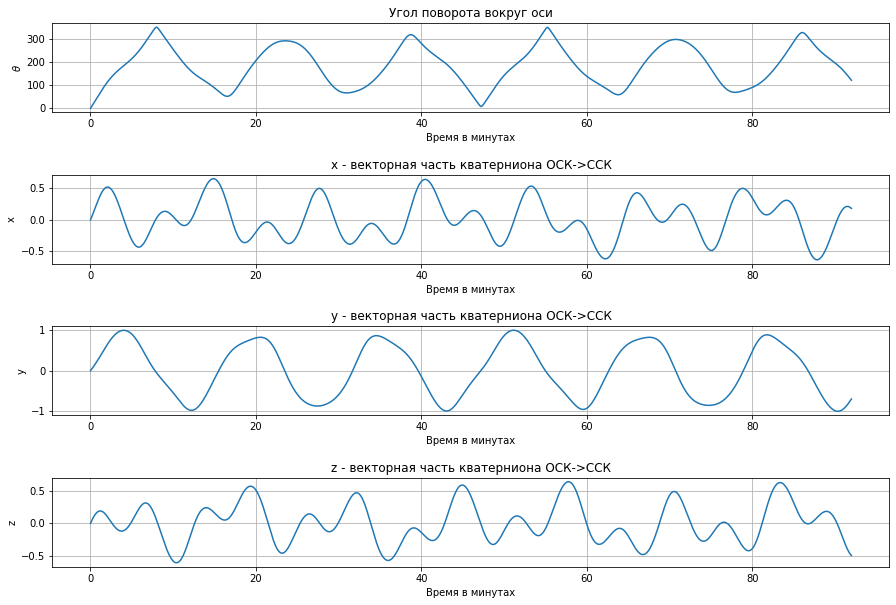

In [9]:
# Графики кватерниона
fig, axes = plt.subplots(4)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.subplots_adjust(hspace = 0.7)

axes[0].plot(timepoints/60,  2 * np.arccos(A3[:, 0]) * 180/np.pi)
axes[0].set_title("Угол поворота вокруг оси")
axes[0].set_xlabel("Время в минутах")
axes[0].set_ylabel(r"$\theta$")
axes[0].grid(True)

axes[1].plot(timepoints/60, A3[:, 1])
axes[1].set_title("x - векторная часть кватерниона ОСК->ССК")
axes[1].set_xlabel("Время в минутах")
axes[1].set_ylabel("x")
axes[1].grid(True)

axes[2].plot(timepoints/60, A3[:, 2])
axes[2].set_title("y - векторная часть кватерниона ОСК->ССК")
axes[2].set_xlabel("Время в минутах")
axes[2].set_ylabel("y")
axes[2].grid(True)

axes[3].plot(timepoints/60, A3[:, 3])
axes[3].set_title("z - векторная часть кватерниона ОСК->ССК")
axes[3].set_xlabel("Время в минутах")
axes[3].set_ylabel("z")
axes[3].grid(True)

### Интеграл Якоби:  
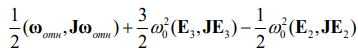
$$
\textbf{w}=\textbf{w}_{ors}+\textbf{w}_{r}\:(r\:-\:relative,\:ors\:-\:orbital\;reference\;system)\\
\textbf{w}_{ors} = \textbf{E}_2\frac{(\textbf{V},\textbf{E}_1)}{r}
$$
(w0 == wors, wr == wотн)

In [10]:
wors = []
for i in range(E3.shape[0]):
    wors.append(E2[i] * np.dot(V[i], E1[i]) / np.linalg.norm(r[i]))
print("Максимальное отклонение орбитальной угловой скорости от начальной (в ИСК):", np.max(np.abs(wors - wors[0])))

for i in range(len(wors)):
    wors[i] = S2[i] @ wors[i]
print("Максимальное отклонение МОДУЛЯ орбитальной угловой скорости от начальной (в ССК):", 
      np.max(np.linalg.norm(wors, axis = 1) - np.linalg.norm(wors[0])))

wors = np.array(wors) # вообще в данном случае орбита круговая и wors +- постоянна по модулю
wr = we - wors # в ССК

Максимальное отклонение орбитальной угловой скорости от начальной (в ИСК): 3.0357660829594124e-17
Максимальное отклонение МОДУЛЯ орбитальной угловой скорости от начальной (в ССК): 3.122502256758253e-17


In [11]:
# Сам интеграл Якоби
J = []
for i in range(wr.shape[0]):
    J.append(0.5 * np.dot(wr[i], params.J @ wr[i]) + 
             np.linalg.norm(wors[i])**2 * 
             (1.5 * np.dot(S2[i] @ E3[i], params.J @ S2[i] @ E3[i]) - 0.5 * np.dot(S2[i] @ E2[i], params.J @ S2[i] @ E2[i])))
J = np.array(J)
print("Максимальное отклонение интеграла Якоби:", np.max(np.abs(J - J[0])))

Максимальное отклонение интеграла Якоби: 5.908901840045999e-18


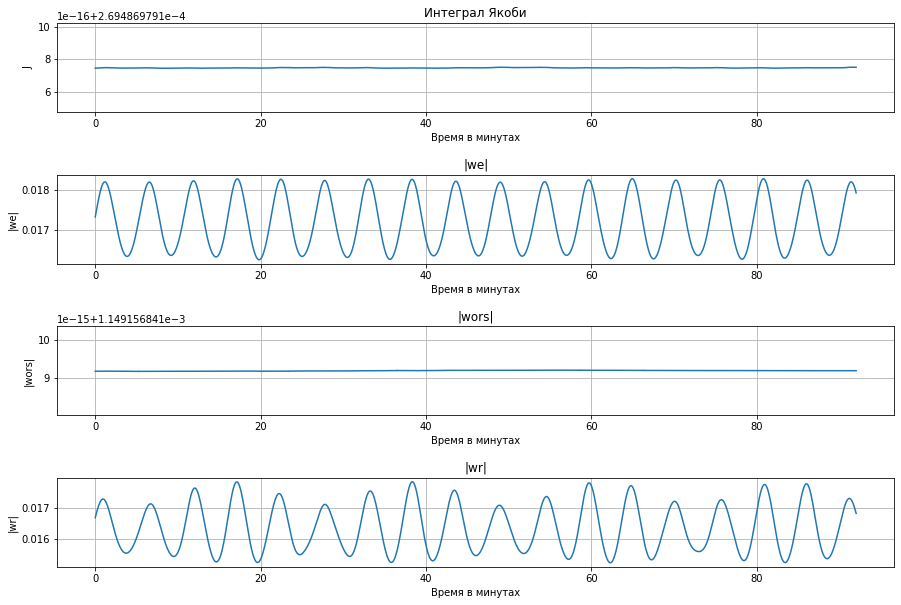

In [12]:
# Интересно посмотреть на графички
fig, axes = plt.subplots(4)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.subplots_adjust(hspace = 0.7)

axes[0].plot(timepoints/60, J)
axes[0].set_title("Интеграл Якоби")
axes[0].set_xlabel("Время в минутах")
axes[0].set_ylabel("J")
axes[0].grid(True)

axes[1].plot(timepoints/60, np.linalg.norm(we, axis = 1))
axes[1].set_title("|we|")
axes[1].set_xlabel("Время в минутах")
axes[1].set_ylabel("|we|")
axes[1].grid(True)

axes[2].plot(timepoints/60, np.linalg.norm(wors, axis = 1))
axes[2].set_title("|wors|")
axes[2].set_xlabel("Время в минутах")
axes[2].set_ylabel("|wors|")
axes[2].grid(True)

axes[3].plot(timepoints/60, np.linalg.norm(wr, axis = 1))
axes[3].set_title("|wr|")
axes[3].set_xlabel("Время в минутах")
axes[3].set_ylabel("|wr|")
axes[3].grid(True)

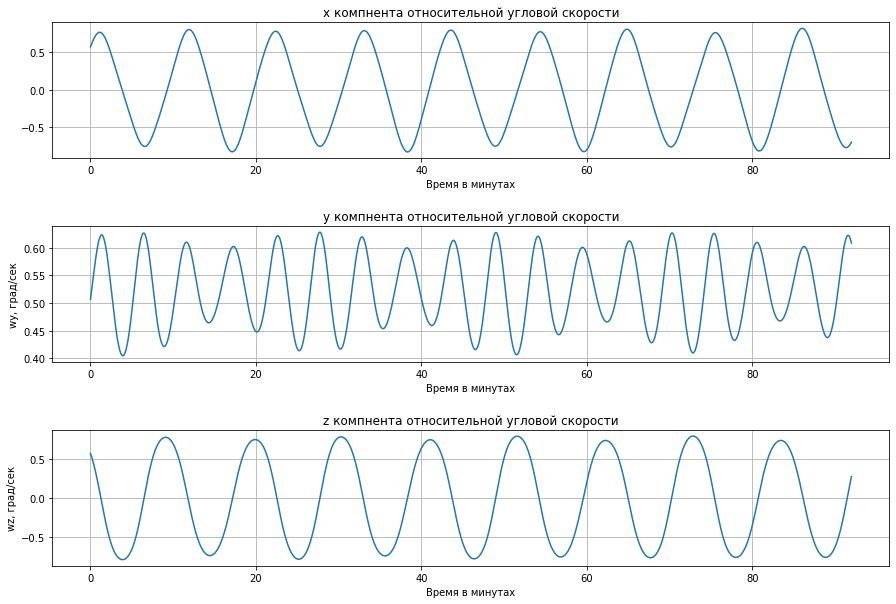

In [13]:
# Графики относительной угловой скорости
fig, axes = plt.subplots(3)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.subplots_adjust(hspace = 0.5)

axes[0].plot(timepoints/60,  wr[:, 0] * 180/np.pi)
axes[0].set_title("x компнента относительной угловой скорости")
axes[0].set_xlabel("Время в минутах")
axes[0].grid(True)

axes[1].plot(timepoints/60, wr[:, 1] * 180/np.pi)
axes[1].set_title("y компнента относительной угловой скорости")
axes[1].set_xlabel("Время в минутах")
axes[1].set_ylabel("wy, град/сек")
axes[1].grid(True)

axes[2].plot(timepoints/60, wr[:, 2] * 180/np.pi)
axes[2].set_title("z компнента относительной угловой скорости")
axes[2].set_xlabel("Время в минутах")
axes[2].set_ylabel("wz, град/сек")
axes[2].grid(True)

### Устойчивое равновесие
Вырезка из лекций Овчинникова М.Ю. по ДОЦМ:  
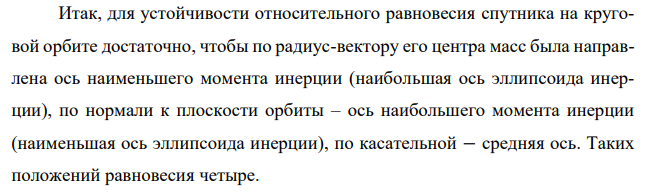

In [14]:
qt.from_rotation_matrix(np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]).T)

quaternion(1, -0, -0, -0)

In [15]:
t0 = 0
t1 = 32*60
step = 1

r0 = np.array([1, 0, 0]) * (constants.RE + constants.ISS_periapsis)
V0 = np.array([0 , 1, 0]) * np.sqrt(params.mu/np.linalg.norm(r0))
we0 = np.array([0, 0, 0.0011491568410391796]) # Положение равновесия
A0 = np.quaternion(1, 0, 0, 0) # ОСК и ССК совпадают

x0 = np.hstack((r0, V0, we0, A0.components))

resultang = RK4(lambda t, x: f(t, x, params), (t0, t1), x0, step, step_process = normalization)

timepoints = resultang[:, 0]
r = resultang[:, 1:4]
V = resultang[:, 4:7]
we = resultang[:, 7:10]
A = resultang[:, 10:]

E3 = np.array([i / np.linalg.norm(i) for i in r])

E1 = np.array([(i - j * np.dot(i, j)) for i, j in zip(V, E3)])
for i in range(E1.shape[0]):
    E1[i] /= np.linalg.norm(E1[i])

E2 = np.array([np.cross(i, j) for i, j in zip(E3, E1)])

S1 = np.array([np.array([E1[i], E2[i], E3[i]]) for i in range(E1.shape[0])]) # матрицы перехода ИСК -> ОСК x' = Sx (НЕ линал)
S2 = np.array([qt.as_rotation_matrix(np.quaternion(*i)).T for i in A]) # матрицы перехода ИСК -> ССК x' = Sx (НЕ линал)
S3 = np.array([j @ i.T for i, j in zip(S1, S2)]) # матрицы перехода ОСК -> ССК x' = Sx (НЕ линал)

In [16]:
A3 = np.array([qt.from_rotation_matrix(i.T).components for i in S3]) # кватернионы поворота ОСК -> CCК

#Мой костыльный метод
# tol = 1.001 * np.max([np.abs((A3[i] - A3[i-1]) * (A3[i] * A3[i-1] > 0)) for i in range(1, A3.shape[0])])
# print(tol)
# for i in range(1, A3.shape[0]):
#     if np.sum(A3[i] * A3[i-1] < 0) == 4:
#         A3[i:] *= -1
#     elif np.sum(A3[i] * A3[i-1] < 0) == 3:
#         j = np.where(A3[i] * A3[i-1] >= 0)[0]
#         if np.allclose(A3[i, j], 0, atol = tol):
#             A3[i:] *= -1
#     elif np.sum(A3[i] * A3[i-1] < 0) == 2:
#         j = np.where(A3[i] * A3[i-1] >= 0)[0]
#         if np.allclose(A3[i, j], 0, atol = tol):
#             A3[i:] *= -1
#     elif np.sum(A3[i] * A3[i-1] < 0) == 1:
#         j = np.where(A3[i] * A3[i-1] >= 0)[0]
#         if np.allclose(A3[i, j], 0, atol = tol):
#             A3[i:] *= -1

tol = 0.1
for i in range(1, A3.shape[0]):
    if np.linalg.norm(A3[i] - A3[i-1]) > tol:
        A3[i:] *= -1

Максимальная норма разницы кватерниона поворота с начальным кватернионом: 1.673760169362752e-14
Это положение равновесия


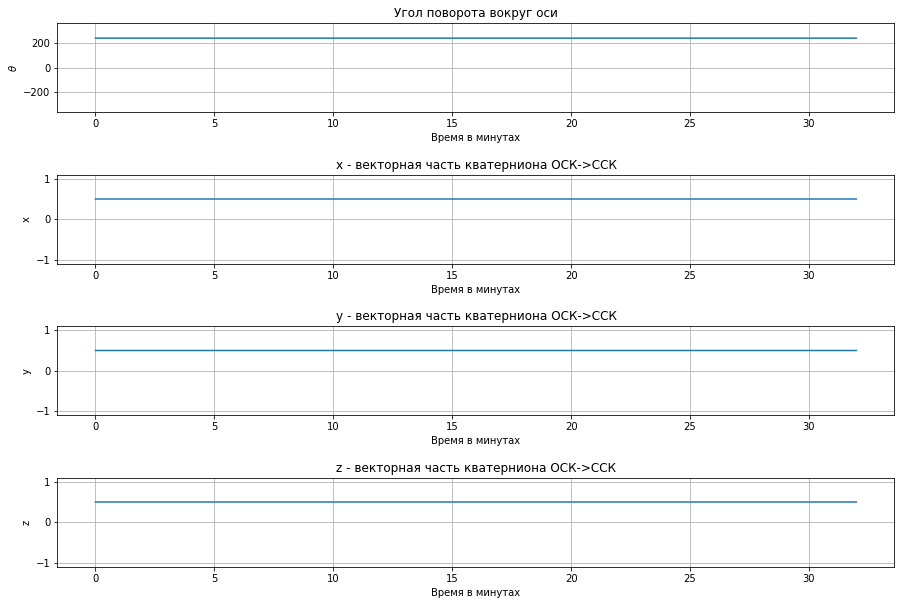

In [17]:
# Графики кватерниона
fig, axes = plt.subplots(4)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.subplots_adjust(hspace = 0.7)

axes[0].plot(timepoints/60,  2 * np.arccos(A3[:, 0]) * 180/np.pi)
axes[0].set_title("Угол поворота вокруг оси")
axes[0].set_xlabel("Время в минутах")
axes[0].set_ylabel(r"$\theta$")
axes[0].set_ylim((-361, 361))
axes[0].grid(True)

axes[1].plot(timepoints/60, A3[:, 1])
axes[1].set_title("x - векторная часть кватерниона ОСК->ССК")
axes[1].set_xlabel("Время в минутах")
axes[1].set_ylabel("x")
axes[1].set_ylim((-1.1, 1.1))
axes[1].grid(True)

axes[2].plot(timepoints/60, A3[:, 2])
axes[2].set_title("y - векторная часть кватерниона ОСК->ССК")
axes[2].set_xlabel("Время в минутах")
axes[2].set_ylabel("y")
axes[2].set_ylim((-1.1, 1.1))
axes[2].grid(True)

axes[3].plot(timepoints/60, A3[:, 3])
axes[3].set_title("z - векторная часть кватерниона ОСК->ССК")
axes[3].set_xlabel("Время в минутах")
axes[3].set_ylabel("z")
axes[3].set_ylim((-1.1, 1.1))
axes[3].grid(True)

print("Максимальная норма разницы кватерниона поворота с начальным кватернионом:", np.max(np.linalg.norm(A3 - A3[0], axis = 1)))
print("Это положение равновесия")

In [18]:
# В задании так же просят построить относительную угловую скорость
wors = []
for i in range(E3.shape[0]):
    wors.append(S2[i] @ E2[i] * np.dot(V[i], E1[i]) / np.linalg.norm(r[i]))

wors = np.array(wors) # вообще в данном случае орбита круговая и wors +- постоянна по модулю
wr = we - wors # в ССК

In [20]:
# И интеграл Якоби
J = []
for i in range(wr.shape[0]):
    J.append(0.5 * np.dot(wr[i], params.J @ wr[i]) + 
             np.linalg.norm(wors[i])**2 * 
             (1.5 * np.dot(S2[i] @ E3[i], params.J @ S2[i] @ E3[i]) - 0.5 * np.dot(S2[i] @ E2[i], params.J @ S2[i] @ E2[i])))
J = np.array(J)
print("Максимальное отклонение интеграла Якоби:", np.max(np.abs(J - J[0])))

Максимальное отклонение интеграла Якоби: 1.0746730518288936e-19


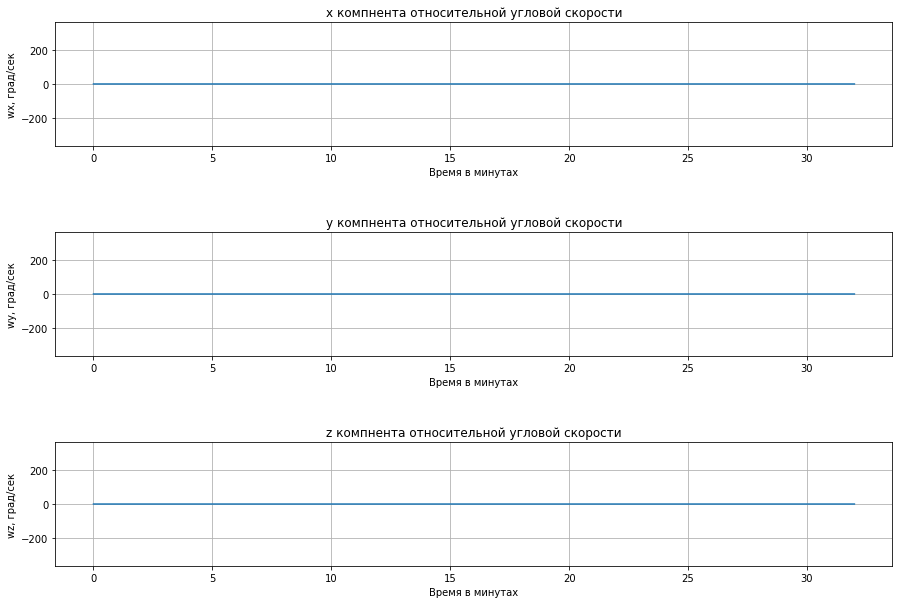

In [19]:
# Графики относительной угловой скорости
fig, axes = plt.subplots(3)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.subplots_adjust(hspace = 0.7)

axes[0].plot(timepoints/60,  wr[:, 0] * 180/np.pi)
axes[0].set_title("x компнента относительной угловой скорости")
axes[0].set_xlabel("Время в минутах")
axes[0].set_ylabel("wx, град/сек")
axes[0].set_ylim((-361, 361))
axes[0].grid(True)

axes[1].plot(timepoints/60, wr[:, 1] * 180/np.pi)
axes[1].set_title("y компнента относительной угловой скорости")
axes[1].set_xlabel("Время в минутах")
axes[1].set_ylabel("wy, град/сек")
axes[1].set_ylim((-361, 361))
axes[1].grid(True)

axes[2].plot(timepoints/60, wr[:, 2] * 180/np.pi)
axes[2].set_title("z компнента относительной угловой скорости")
axes[2].set_xlabel("Время в минутах")
axes[2].set_ylabel("wz, град/сек")
axes[2].set_ylim((-361, 361))
axes[2].grid(True)